In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.parametrize as P
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from torchdiffeq import odeint


In [58]:
def lp_norm_loss(y, yhat, p=2):
    return torch.pow(torch.norm(y-yhat, p=p), p)

## Generate Data

In [59]:
t_sample = 0.01
T = 100

time_points = torch.linspace(0, T, int(T/t_sample)+1)

In [60]:
class SIR_ODE(nn.Module):

    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, t, x):
        rhs = torch.zeros_like(x)
        # compute SIR model ODE RHS
        rhs[0] = -self.beta*x[0]*x[1]
        rhs[1] = self.beta*x[0]*x[1] - self.gamma*x[1]
        rhs[2] = self.gamma*x[1]
        return rhs

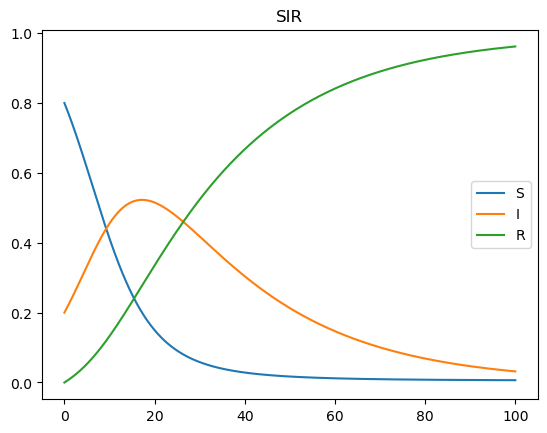

In [61]:
beta = 0.2
gamma = 0.04
sir_0 = [0.8, 0.2, 0]
x0 = torch.tensor(sir_0, dtype=torch.float32)

SIR_data = odeint(SIR_ODE(beta, gamma), x0, time_points)


states = ["S","I","R"]

for i in range(3):
    plt.title("SIR")
    plt.plot(time_points, SIR_data[:,i], label=states[i])
    plt.legend()

## Model Fitting

In [62]:
class nUIV_rhs(nn.Module):
    '''
    networked UIV model object
    holds an ODE defining a network of in-host models.
    Defined using pytorch tensors for interface with Neural ODE library.
    beta, delta, c, and p for each host are randomly initialized
    transmissions between hosts are randomly initialized. Could be constrained if we wanted to enforce more structure.
    args:
        N (int): number of hosts
    '''
    def __init__(self, N: int):
        super(nUIV_rhs, self).__init__()
        self.N = N
        self.betas = nn.Parameter(torch.rand((self.N,)))
        self.deltas = nn.Parameter(torch.rand((self.N,)))
        self.cs = nn.Parameter(torch.rand((self.N,)))
        self.ps = nn.Parameter(torch.rand((self.N,)))
        self.ts = nn.Parameter((torch.eye(self.N) + torch.rand((self.N, self.N)))/2.0)

    def forward(self, t, state):
        rhs = torch.zeros_like(state)  # (U, I, V) RHS's for each node
        rhs[::3] = -self.betas*state[::3]*state[2::3]
        rhs[1::3] = self.betas*state[::3]*state[2::3] - self.deltas*state[1::3]
        rhs[2::3] = self.ps*state[1::3] - self.cs*state[2::3] + torch.matmul(state[2::3], self.ts)
        return rhs

In [63]:
class soft_threshold(nn.Module):
    '''
    function for mapping from a single host's UIV state to their SIR state.
    Currently defined as a linear map plus a soft-thresholding operator.
    '''
    def __init__(self, bias=False, nonlinearity=False):
        super().__init__()
        if nonlinearity:
            self.slope = nn.Parameter(torch.tensor(1.0))  # *torch.ones(3)
            self.threshold = nn.Parameter(torch.rand(3)*200)  # nn.Parameter(torch.rand(3))
            self.act = nn.Sigmoid()
            self.W = nn.Linear(3, 3, bias=bias)
            self.forward = self.forward_nonlinear
        else:
            self.W = nn.Linear(3, 3, bias=bias)  # linear map
            self.forward = self.forward_linear

    def forward_linear(self, UIV_host):
        return torch.nn.functional.normalize(self.W(UIV_host), p=1, dim=-1)

    def forward_nonlinear(self, UIV_host):
        return torch.nn.functional.normalize(torch.sigmoid(self.slope*(UIV_host-self.threshold)), p=1, dim=-1)
        # return self.act(UIV_host-self.threshold)  # 1.0/(1.0 + torch.exp(-self.slope*(UIV_host - self.threshold)))


In [64]:
class nUIV_NODE(nn.Module):
    
    def __init__(self, num_hosts: int, **kwargs):
        super().__init__()
        self.num_hosts = torch.tensor(num_hosts)
        self.nUIV_x0 = nn.Parameter(torch.rand(3*self.num_hosts))  # initialize a random initial state
        self.nUIV_dynamics = nUIV_rhs(self.num_hosts)  # initialize a random nUIV
        self.nUIV_to_SIR = soft_threshold(nonlinearity=kwargs.pop('nonlinearity', False))

        self.method = kwargs.pop('method', 'rk4')
        self.step_size = kwargs.pop('step_size', None)

    def simulate(self, times):
        solution = odeint(self.nUIV_dynamics, self.nUIV_x0,
                          times, method=self.method, options=dict(step_size=self.step_size)).to(times.device)  # shape T x 3*num_hosts
        # SIR = torch.zeros(3, len(times), device=times.device)
        SIR = torch.mean(self.nUIV_to_SIR(torch.reshape(solution, (len(times), self.num_hosts, 3))), axis=1).transpose(0, 1)  # result should be 3 x T
        return SIR

In [65]:
num_hosts = 10
step_size = t_sample/2.0
method = 'euler'
nonlinearity = True
device = 'cpu'

model = nUIV_NODE(num_hosts, method=method, step_size=step_size, nonlinearity=nonlinearity)

In [66]:
num_epochs = 200
lr = 5E-4
weight_decay = 0.0
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)
only_II_fit = lambda y, yhat: torch.nn.functional.l1_loss(yhat[1, :], y[1, :])
Lp_loss = lambda y, yhat: torch.nn.functional.mse_loss(y, yhat)  # , p=2)  # nn.L1Loss()

loss_function = only_II_fit

In [67]:
# INITIALIZE MODEL WITH REASONABLE PARAMETERS
with torch.no_grad():
    U0 = 4E8  # taken from paper
    I0 = 50  # taken from paper
    V0 = 50  # taken from paper
    UIV_time_scale = 1

    # the initial states will be drawn uniformly at random in the interval
    #  [U0 * (1-percent_interval), U0*(1+percent_interval)].

    percent_interval = 0.01  # what % around the mean value are we willing to permit randomness about?
    U0_u = 9E8   # U0*(1+percent_interval)
    U0_l = 1E8  # U0*(1-percent_interval)
    I0_u = I0*(1+percent_interval)
    I0_l = I0*(1-percent_interval)
    V0_u = 200  # V0*(1+percent_interval)
    V0_l = 0  # V0*(1-percent_interval)

    # all initial states are in interval [0, 1].  Need to center them on U0, I0, V0 and scale them in the interval
    nUIV_x0_initial = torch.zeros_like(model.nUIV_x0)
    nUIV_x0_initial[::3] = U0_l + model.nUIV_x0[::3]*(U0_u - U0_l)
    nUIV_x0_initial[1::3] = I0_l + model.nUIV_x0[1::3]*(I0_u - I0_l)
    nUIV_x0_initial[2::3] = V0_l + model.nUIV_x0[2::3]*(V0_u - V0_l)
    model.nUIV_x0 = nUIV_x0_initial

    beta_l = UIV_time_scale*0.01E-8
    beta_u = UIV_time_scale*30E-8
    beta_m = UIV_time_scale*3E-8

    model.nUIV_dynamics.betas = beta_l + model.nUIV_dynamics.betas*(beta_u - beta_l)

    delta_l = UIV_time_scale*0.5
    delta_u = UIV_time_scale*3.0
    delta_m = UIV_time_scale*1.5

    model.nUIV_dynamics.deltas = delta_l + model.nUIV_dynamics.deltas*(delta_u - delta_l)

    p_l = UIV_time_scale*0.2
    p_u = UIV_time_scale*35.0  # 350
    p_m = UIV_time_scale*4.0

    model.nUIV_dynamics.ps = p_l + model.nUIV_dynamics.ps*(p_u-p_l)

    R0_l = UIV_time_scale*4.0
    R0_u = UIV_time_scale*70.0
    R0_m = UIV_time_scale*18.0

    c_l = U0*p_l*beta_l/(R0_l*delta_l)
    c_u = U0*p_u*beta_u/(R0_u*delta_u)
    c_m = U0*p_m*beta_m/(R0_m*delta_m)

    model.nUIV_dynamics.ts = c_l + model.nUIV_dynamics.ts*(c_u - c_l)
    if nonlinearity:
        # model.nUIV_to_SIR.threshold[0] = 100
        # model.nUIV_to_SIR.threshold[1] = 100
        # model.nUIV_to_SIR.threshold[2] = 100
        model.nUIV_to_SIR.threshold.data = torch.tensor(150.0)
    else:
        model.nUIV_to_SIR.W.weight.data[:, 0] = model.nUIV_to_SIR.W.weight.data[:, 0]*1E-9  # Need to drastically re-scale the UIV->SIR map
        model.nUIV_to_SIR.W.weight.data[:, 1] = model.nUIV_to_SIR.W.weight.data[:, 1]*1E-9
        model.nUIV_to_SIR.W.weight.data[:, 2] = model.nUIV_to_SIR.W.weight.data[:, 2]*1E-9

TypeError: cannot assign 'torch.FloatTensor' as parameter 'nUIV_x0' (torch.nn.Parameter or None expected)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

nUIV_x0 tensor([0.1570, 0.5002, 0.9802, 0.7659, 0.8658, 0.1836, 0.2469, 0.1757, 0.1953,
        0.7494, 0.6184, 0.0779, 0.2209, 0.7709, 0.5327, 0.0469, 0.5632, 0.6832,
        0.7023, 0.9349, 0.2904, 0.0757, 0.7321, 0.0174, 0.9055, 0.0427, 0.4291,
        0.3060, 0.6861, 0.6817])
nUIV_dynamics.betas tensor([0.4580, 0.9881, 0.5412, 0.9320, 0.4449, 0.3624, 0.4594, 0.2270, 0.5698,
        0.0244])
nUIV_dynamics.deltas tensor([0.6128, 0.9700, 0.1940, 0.2524, 0.2976, 0.2332, 0.2856, 0.6107, 0.5407,
        0.0773])
nUIV_dynamics.cs tensor([0.7792, 0.9272, 0.9917, 0.6083, 0.9690, 0.1389, 0.7718, 0.6449, 0.7399,
        0.4994])
nUIV_dynamics.ps tensor([0.1374, 0.4452, 0.6347, 0.0088, 0.3093, 0.9254, 0.8270, 0.2491, 0.4943,
        0.6062])
nUIV_dynamics.ts tensor([[0.9716, 0.2918, 0.1079, 0.3031, 0.1395, 0.2384, 0.2954, 0.3038, 0.2791,
         0.2840],
        [0.3351, 0.7357, 0.4622, 0.4854, 0.0712, 0.1333, 0.1947, 0.2430, 0.2297,
         0.0148],
        [0.4913, 0.3218, 0.8949, 0.2522, 

In [37]:
SIR_train_data = torch.t(SIR_data)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_points)
    # print(SIR_est)
    # print(SIR_est.shape)
    loss = loss_function(SIR_est, SIR_train_data)
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    if scheduler:
        scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: nan.


ValueError: Found NaN loss, exiting...